In [1]:
from helpers import *
from dataset import *
from model2 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
DEBAG = False

In [3]:
mask_size2 = {key: math.floor(value * 1.5) for key, value in mask_size.items()}
mask_size2

{'defolt': 1,
 'apo-ferritin': 9,
 'beta-amylase': 10,
 'beta-galactosidase': 13,
 'ribosome': 22,
 'thyroglobulin': 19,
 'virus-like-particle': 21}

In [4]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

(6, 184, 630, 630)
(6, 184, 630, 630)


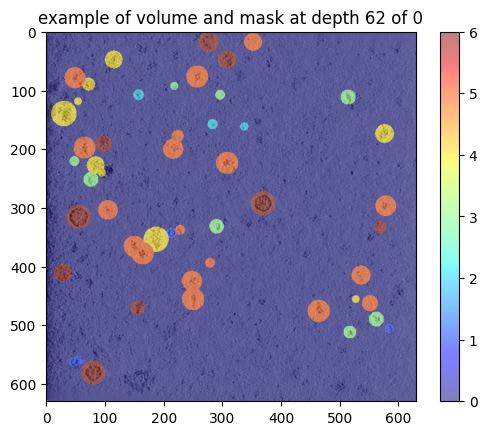

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

valid_id = ['TS_99_9', "TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4"]
test_id = ["TS_99_9","TS_5_4"]

volumes = np.empty((len(valid_id), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id), 184, 630, 630), dtype=np.uint8)

for idx in range(len(valid_id)):
    data = read_one_data(valid_id[idx], train_dir)
    data = data.astype(np.float32)
    volumes[idx, :, :, :] = data
    
    y = read_one_truth(valid_id[idx], mask_dir)
    mask_data = generate_mask(y, mask_size2)
    mask_data = mask_data.astype(np.uint8)
    masks[idx, :, :, :] = mask_data

print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=62)

In [6]:
vol_data = []
mask_data = []
for exp in range(len(valid_id)):
    vol_slices_list = []
    mask_slices_list = []

    volume = volumes[exp, :, :, :]
    mask = masks[exp, :, :, :]
    print("exp=", exp)
    
    #何もなし
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=0, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)
    if DEBAG:
        combined_vol_slices = np.concatenate(vol_slices_list, axis=0)
        combined_mask_slices = np.concatenate(mask_slices_list, axis=0)

        vol_data.append(combined_vol_slices)
        mask_data.append(combined_mask_slices)
        continue
    # 180度回転
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=30, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)

    #斜め
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=2, angley=2, anglez=2, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)


    combined_vol_slices = np.concatenate(vol_slices_list, axis=0)
    combined_mask_slices = np.concatenate(mask_slices_list, axis=0)

    vol_data.append(combined_vol_slices)
    mask_data.append(combined_mask_slices)

vol_data = np.concatenate(vol_data, axis=0)
mask_data = np.concatenate(mask_data, axis=0)

print("vol_data shape:", vol_data.shape)
print("mask_data shape:", mask_data.shape)

exp= 0
-73 -44 44
19 73 28
36 -53 12
19 36 -4
62 -85 -20
-50 -96 -36
-22 27 -52
25 -68 -68
-24 50 -84
vol_slices shape: (9, 32, 640, 640)
21 23 44
-22 -14 28
63 14 12
-64 -63 -4
86 54 -20
-78 93 -36
79 -69 -52
24 79 -68
-93 -78 -84
vol_slices shape: (9, 32, 640, 640)
36 -83 44
-59 -72 28
45 -69 12
-100 -93 -4
-44 61 -20
-100 -41 -36
46 -27 -52
-98 39 -68
1 15 -84
vol_slices shape: (9, 32, 640, 640)
exp= 1
23 -96 44
32 73 28
-24 -99 12
10 -64 -4
89 -56 -20
-16 -98 -36
-41 50 -52
43 -66 -68
-85 11 -84
vol_slices shape: (9, 32, 640, 640)
90 -65 44
83 9 28
2 -23 12
17 -24 -4
73 -29 -20
-43 -49 -36
14 78 -52
96 81 -68
79 62 -84
vol_slices shape: (9, 32, 640, 640)
-31 3 44
-67 -44 28
11 -99 12
-28 52 -4
11 38 -20
-57 56 -36
-69 -80 -52
-73 -47 -68
-18 -78 -84
vol_slices shape: (9, 32, 640, 640)
exp= 2
-8 -21 44
26 -21 28
-15 0 12
-71 10 -4
-34 33 -20
15 44 -36
-36 -23 -52
46 14 -68
75 -27 -84
vol_slices shape: (9, 32, 640, 640)
-7 93 44
-16 -44 28
17 68 12
51 -10 -4
65 -51 -20
98 58 -36
-26 

In [7]:
class VolumeDataset(Dataset):
    def __init__(self, vol_data, mask_data, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, 32, 640, 640) を想定
            mask_data (numpy.ndarray): 形状 (N, 32, 640, 640) を想定
            transform (callable, optional): 
                MONAIの辞書ベースのTransformsなどを含むパイプライン。
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.transform = transform

    def __len__(self):
        # サンプル数を返す
        return len(self.vol_data)

    def __getitem__(self, idx):
        # 1. Pythonの辞書形式でデータを作る
        data_dict = {
            "image": self.vol_data[idx],  # (32, 640, 640)
            "label": self.mask_data[idx], # (32, 640, 640)
        }

        # 2. 辞書ベースのトランスフォームを適用
        if self.transform:
            data_dict = self.transform(data_dict)

        # 3. 変換後のデータを取り出して返す
        volume = data_dict["image"]
        mask   = data_dict["label"]

        return volume, mask


# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    ToTensorD(keys=["image", "label"]),  # まずテンソルに変換
    NormalizeIntensityd(
        keys=["image"], 
        nonzero=False,      # ゼロ以外のボクセルに限定せず全体で正規化する例
        channel_wise=False  # チャネルごとの正規化をしない（1チャネル想定ならFalseでOK）
    ),
])


In [8]:
# Dataset のインスタンスを作成
dataset = VolumeDataset(vol_data, mask_data, transform=transforms)

# DataLoader のインスタンスを作成
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = Net(pretrained=True,cfg=None).cuda()

cuda


In [10]:
# 学習ループにCV計算を追加
num_epochs = 20
learning_rate = 1e-3
optimizer = torch.optim.AdamW(
    net.parameters(), 
    lr=learning_rate,
    weight_decay=0.01
)
scaler = torch.cuda.amp.GradScaler(init_scale=4096)
epoch_losses = []
cv_scores = []  # CVスコアの記録リスト

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        optimizer = torch.optim.AdamW(
            net.parameters(), 
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }
        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss']

        running_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"損失: {epoch_loss:.4f}")

    # エポックごとにCVスコアを計算
    gb, lb_score = evaluate_cv(net, test_id, cfg, valid_dir, device,mask_size)  # test_id: 検証用データIDリスト
    cv_scores.append(lb_score)
    print(f"CVスコア: lb_score: {lb_score:.4f}")

# 最終的なスコアを出力
print("\n全エポックの結果:")
for epoch, (loss, lb_score) in enumerate(zip(epoch_losses, cv_scores), start=1):
    print(f"エポック {epoch}: 損失: {loss:.4f}, lb_score: {lb_score:.4f}")


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/20
----------
損失: 0.8990
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.23742311596870422
Evaluating CV for ID TS_5_4 (2/2)
mask_loss=0.2026825338602066
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
(         particle_type     P   T  hit  miss    fp  precision    recall  \
0         apo-ferritin   227  82    0    82   227   0.000000  0.000000   
1         beta-amylase   249  31    0    31   249   0.000000  0.000000   
2   beta-galactosidase   172  36    0    36   172   0.000000  0.000000   
3             ribosome   735  96   13    83   722   0.017687  0.135417   
4        thyroglobulin   626  79    3    76   623   0.004792  0.037975   
5  virus-like-particle  1073  24   12    12  1061   0.011184  0.500000   

    f-beta4  weight  
0  0.000000       1  
1  0.000000       0  
2  0.000000       2  
3  0.097314       1  
4  0.026984       2  
5  0.140014       1  , 0.0416137056303944)
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
CVスコア: lb_score: 0.0416
エポック 2/20
---------

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.1137
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.11676198989152908
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.10016541965305806
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  352  36   11    25  341   0.031250  0.305556   
1         beta-amylase  177  21    1    20  176   0.005650  0.047619   
2   beta-galactosidase  234  24   16     8  218   0.068376  0.666667   
3             ribosome  237  65   12    53  225   0.050633  0.184615   
4        thyroglobulin  248  49   28    21  220   0.112903  0.571429   
5  virus-like-particle  370  13   11     2  359   0.029730  0.846154   

    f-beta4  weight  
0  0.201509       1  
1  0.033138       0  
2  0.440129       2  
3  0.159749       1  
4  0.461240       2  
5  0.323529       1  , 0.35536099499596546)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.3554
エポック 6/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0858
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.21411870419979095
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.11329126097261906
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  13  36    6    30   7   0.461538  0.166667  0.173175   
1         beta-amylase   0  21    0    21   0   0.000000  0.000000  0.000000   
2   beta-galactosidase  11  24    0    24  11   0.000000  0.000000  0.000000   
3             ribosome  11  65    1    64  10   0.090909  0.015385  0.016175   
4        thyroglobulin   8  49    0    49   8   0.000000  0.000000  0.000000   
5  virus-like-particle  18  13    4     9  14   0.222222  0.307692  0.300885   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  , 0.07003355711119374)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.0700
エポック 7/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0687
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.16848522946238517
Evaluating CV for ID TS_5_4 (2/2)
mask_loss=0.13840180337429048
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
(         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  847  82    7    75  840   0.008264  0.085366   
1         beta-amylase    0  31    0    31    0   0.000000  0.000000   
2   beta-galactosidase  853  36    5    31  848   0.005862  0.138889   
3             ribosome   19  96    7    89   12   0.368421  0.072917   
4        thyroglobulin   42  79    0    79   42   0.000000  0.000000   
5  virus-like-particle   98  24   13    11   85   0.132653  0.541667   

    f-beta4  weight  
0  0.055118       1  
1  0.000000       0  
2  0.059482       2  
3  0.076527       1  
4  0.000000       2  
5  0.458506       1  , 0.10130228231415846)
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
CVスコア: lb_score: 0.1013
エポック 8/20
----------
損失: 0.0575
Evaluating CV for ID

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0436
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.25200055539608
Evaluating CV for ID TS_5_4 (2/2)
mask_loss=0.17650738582015038
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
(         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  534  82   12    70  522   0.022472  0.146341   
1         beta-amylase    6  31    0    31    6   0.000000  0.000000   
2   beta-galactosidase   17  36    0    36   17   0.000000  0.000000   
3             ribosome    3  96    2    94    1   0.666667  0.020833   
4        thyroglobulin    7  79    0    79    7   0.000000  0.000000   
5  virus-like-particle   16  24    9    15    7   0.562500  0.375000   

    f-beta4  weight  
0  0.110509       1  
1  0.000000       0  
2  0.000000       2  
3  0.022092       1  
4  0.000000       2  
5  0.382500       1  , 0.0735859252581516)
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
CVスコア: lb_score: 0.0736
エポック 11/20
----------
損失: 0.0409
Evaluating CV for ID TS

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0354
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.23490489795804023
Evaluating CV for ID TS_5_4 (2/2)
mask_loss=0.17622047066688537
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
(         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  201  82   11    71  190   0.054726  0.134146   
1         beta-amylase   14  31    0    31   14   0.000000  0.000000   
2   beta-galactosidase   13  36    0    36   13   0.000000  0.000000   
3             ribosome   18  96    5    91   13   0.277778  0.052083   
4        thyroglobulin   28  79    0    79   28   0.000000  0.000000   
5  virus-like-particle   35  24   13    11   22   0.371429  0.541667   

    f-beta4  weight  
0  0.123596       1  
1  0.000000       0  
2  0.000000       2  
3  0.054698       1  
4  0.000000       2  
5  0.527446       1  , 0.10081990871878894)
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
CVスコア: lb_score: 0.1008
エポック 13/20
----------
損失: 0.0334
Evaluating CV for I

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0351
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.24817534387111664
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.17657987475395204
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  66  36   13    23  53   0.196970  0.361111  0.344237   
1         beta-amylase  21  21    0    21  21   0.000000  0.000000  0.000000   
2   beta-galactosidase   9  24    1    23   8   0.111111  0.041667  0.043257   
3             ribosome   1  65    0    65   1   0.000000  0.000000  0.000000   
4        thyroglobulin   3  49    0    49   3   0.000000  0.000000  0.000000   
5  virus-like-particle  10  13    8     5   2   0.800000  0.615385  0.623853   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  , 0.1506577094349609)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.1507
エポック 15/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0288
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.24000741243362428
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.1800988908857107
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  108  36   14    22  94   0.129630  0.388889  0.347953   
1         beta-amylase   25  21    0    21  25   0.000000  0.000000  0.000000   
2   beta-galactosidase   10  24    2    22   8   0.200000  0.083333  0.086294   
3             ribosome   16  65    3    62  13   0.187500  0.046154  0.048295   
4        thyroglobulin    3  49    0    49   3   0.000000  0.000000  0.000000   
5  virus-like-particle   36  13   13     0  23   0.361111  1.000000  0.905738   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  , 0.21065360118929516)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.2107
エポック 16/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0283
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.31220162063837054
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.23807477056980134
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  62  36   13    23  49   0.209677  0.361111  0.346395   
1         beta-amylase   5  21    0    21   5   0.000000  0.000000  0.000000   
2   beta-galactosidase   2  24    0    24   2   0.000000  0.000000  0.000000   
3             ribosome  12  65    1    64  11   0.083333  0.015385  0.016160   
4        thyroglobulin  32  49    0    49  32   0.000000  0.000000  0.000000   
5  virus-like-particle  20  13   13     0   7   0.650000  1.000000  0.969298   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  , 0.1902647036796492)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.1903
エポック 17/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0266
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.3007026150822639
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.1961345113813877
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  234  36   13    23  221   0.055556  0.361111   
1         beta-amylase    1  21    0    21    1   0.000000  0.000000   
2   beta-galactosidase    0  24    0    24    0   0.000000  0.000000   
3             ribosome    1  65    1    64    0   1.000000  0.015385   
4        thyroglobulin    0  49    0    49    0   0.000000  0.000000   
5  virus-like-particle   13  13    9     4    4   0.692308  0.692308   

    f-beta4  weight  
0  0.272840       1  
1  0.000000       0  
2  0.000000       2  
3  0.016330       1  
4  0.000000       2  
5  0.692308       1  , 0.14021109285278352)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.1402
エポック 18/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0264
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.3303856074810028
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.22038018852472305
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  125  36   13    23  112   0.104000  0.361111   
1         beta-amylase    0  21    0    21    0   0.000000  0.000000   
2   beta-galactosidase    0  24    0    24    0   0.000000  0.000000   
3             ribosome    2  65    0    65    2   0.000000  0.000000   
4        thyroglobulin    3  49    0    49    3   0.000000  0.000000   
5  virus-like-particle    9  13    8     5    1   0.888889  0.615385   

    f-beta4  weight  
0  0.315264       1  
1  0.000000       0  
2  0.000000       2  
3  0.000000       1  
4  0.000000       2  
5  0.626728       1  , 0.13457028847156186)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.1346
エポック 19/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0229
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.34405860006809236
Evaluating CV for ID TS_5_4 (2/2)
location_df is empty, 
mask_loss=0.25515192151069643
['TS_99_9']
 TS_99_9 virus-like-particle
(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  75  36   12    24  63   0.160000  0.333333  0.313364   
1         beta-amylase   0  21    0    21   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   0  24    0    24   0   0.000000  0.000000  0.000000   
3             ribosome   1  65    0    65   1   0.000000  0.000000  0.000000   
4        thyroglobulin   0  49    0    49   0   0.000000  0.000000  0.000000   
5  virus-like-particle  12  13    7     6   5   0.583333  0.538462  0.540909   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  , 0.12203902088694715)
['TS_99_9']
 TS_99_9 virus-like-particle
CVスコア: lb_score: 0.1220
エポック 20/20
----------


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


損失: 0.0203
Evaluating CV for ID TS_99_9 (1/2)
mask_loss=0.2867382735013962
Evaluating CV for ID TS_5_4 (2/2)
mask_loss=0.23000552952289582
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
(         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  147  82   13    69  134   0.088435  0.158537   
1         beta-amylase   98  31    0    31   98   0.000000  0.000000   
2   beta-galactosidase    0  36    0    36    0   0.000000  0.000000   
3             ribosome    8  96    4    92    4   0.500000  0.041667   
4        thyroglobulin   17  79    0    79   17   0.000000  0.000000   
5  virus-like-particle   21  24   13    11    8   0.619048  0.541667   

    f-beta4  weight  
0  0.151474       1  
1  0.000000       0  
2  0.000000       2  
3  0.044041       1  
4  0.000000       2  
5  0.545679       1  , 0.10588486788370542)
['TS_99_9', 'TS_5_4']
 TS_5_4 virus-like-particlee
CVスコア: lb_score: 0.1059

全エポックの結果:
エポック 1: 損失: 0.8990, lb_score: 0.0416
エポック 

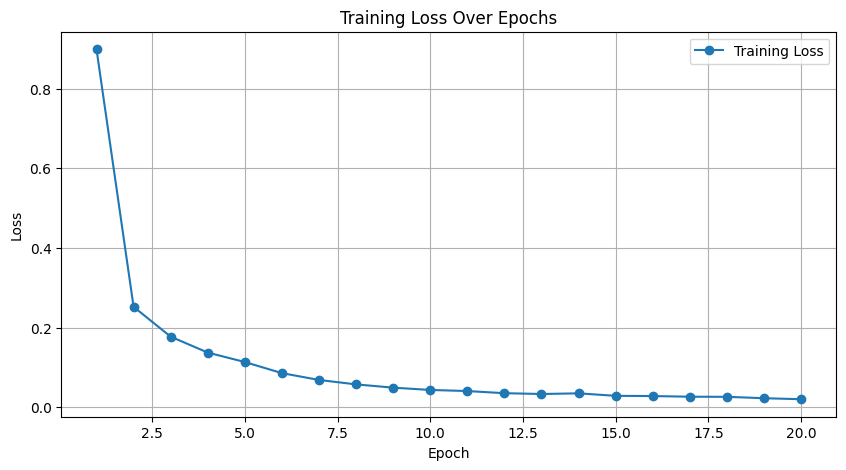

In [11]:
# 損失の推移をグラフ化
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()